# Clasificador binario mejorado

Aqui realizaremos un analisis mas extenso sobre el clasificador binario utilizando el metodo de redes neuronales. Exploraremos sus posibles errores y como mejorar sus resultados hasta el maximo posible.

Los pasos a explorar son:
* introducir mas variables y quitar otras
* entrenar el clasificador para una sola estacion desde la cual tengamos muchos datos
* analizar los errores (casos de falsos negativos) e intentar entender por que ocurren
* buscar la configuracion optima para la estacion en cuestion.
* generar una funcion simple que permita llamar al clasificador y entregue la probabilidad de que ocurra la helada (no necesariamente decir "si" o "no")

#### la configuracion basica del clasificador consistira de 2 casos:
* recibe como inputs los datos medidos a las 14 y 20 horas del mismo dia
* recibe como inputs los datos medidos a las 20 horas del dia actual y el dia anterior

#### La arquitectura sera:
* salida de una neurona para clasificar binariamente
* funcion de activacion relu
* optimizador adagrad
* numero de hidden layers por evaluar


In [1]:
import pickle
import numpy as np
import sys
sys.path.append("../")
from regressor.regressor import Regressor, r_square, rmse
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.utils import resample
from keras.callbacks import EarlyStopping
import keras

Using TensorFlow backend.


In [2]:
def runMLP(X_train, X_test, y_train, y_test, verbose=True, weight=True):
    in_dim = X_train.shape[1]
    out_dim = 2
    estop = EarlyStopping(monitor="val_loss", patience=30, verbose=True, mode="min", min_delta=0.01)
    reg = Regressor(input_dim=in_dim, output_dim=out_dim, n=3, layer_size=100, 
                loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], early_stopping=estop,
                out_activation="softmax")
    reg.build()
    y_train_class = keras.utils.to_categorical(y_train,2)
    y_test_class = keras.utils.to_categorical(y_test,2)
    
    class_weights = None
    if weight:
        class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), 
                                                y_train)
        class_weights = {0: class_weights[0], 1: class_weights[1]}
        print(class_weights)
#     class_weights = {0: 1, 1: 17.7}
#     cls_weight_dict = {0: cls_weights[0], 1: cls_weights[1]}
#     val_sample_weights = class_weight.compute_sample_weight(cls_weight_dict, y_test._values)
    
    history = reg.fit(X_train, y_train_class, verbose=verbose, epochs=500, batch_size=320, 
                      validation_split=0.2, shuffle=True, class_weight=class_weights)
    if verbose:
        reg.plot_metrics()
    scores = reg.evaluate(X_test, y_test_class)
    return scores, reg

def cv_mlp(X, y, cv=10, weight=True):
    skf = StratifiedKFold(n_splits=cv)
    srcs = []
    for train_index, test_index in skf.split(X, y):
        print("iteration!...")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        outs, _ = runMLP(X_train, X_test, y_train, y_test, verbose=False, weight=weight)
        srcs.append(outs)
        keras.backend.clear_session()
    
    return srcs
    
def prob(outs):
    accs = []
    for o in outs:
        accs.append(o[1])
    
    print("mean: ", np.mean(accs), end=", ")
    print("median: ", np.median(accs), end=", ")
    print("std: ", np.std(accs), end=", ")

In [3]:
def load_data_small():
    pckl_in = open("../data/dias_limpiados3.pkl", "rb")
    pckl = pickle.load(pckl_in)
    hrs14 = 5
    hrs20 = 11
    hrs12 = 3
    hrs16 = 7
    K = 0
    data = np.full((pckl.shape[0], 17), None)
    for i in range(pckl.shape[0]):
        if i % 100 == 0:
            print(i, end="\r")
        line = pckl.iloc[i]
        k = 0
        for j in [hrs14, hrs20]:
            data[i][k] = line["Temp"][j]
            data[i][1+k] = line["PAtm"][j]
            data[i][2+k] = line["Hume"][j]
            data[i][3+k] = line["RadS"][j]
            data[i][4+k] = line["Vien"][j]
            k += 5
        data[i][k] = np.min(line["Temp"])
        data[i][k + 1] = int(line["Helada"])
        K = k + 2
    data = data[:,:K]
    return data, data[:,:-2], data[:,-1].astype(int)

In [98]:
data_single, X_single, y_single = load_data_small()
X_scaled_single = preprocessing.scale(X_single)
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(X_scaled_single, list(y_single), 
                                                                                test_size=0.2, stratify=y_single)
scores, reg_single = runMLP(X_train_single, X_test_single, y_train_single, y_test_single, verbose=False)
y_pred_single = (reg_single.predict(X_test_single)[:,1] > 0.5).astype(int)
print(confusion_matrix(y_test_single, y_pred_single))
print(classification_report(y_test_single, y_pred_single))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               1100      
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 202       
Total params: 21,502
Trainable params: 21,502
Non-trainable params: 0
_________________________________________________________________
{0: 0.5316656111462951, 1: 8.395}
Epoch 00051: early stopping
evaluando test
420/420 [==============================] - 0s 64us/step
    EVALUATION RESULTS :  
loss: 0.20
accuracy: 0.92
accuracy_1: 0.92
[[366  29]
 [  6  19]]
              precisio

In [88]:
data, X, y = load_data_small()
X_scaled = preprocessing.scale(X)
outs_single = cv_mlp(X_scaled, y, cv=10)
prob(outs)

iteration!...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 21,502
Trainable params: 21,502
Non-trainable params: 0
_________________________________________________________________
{0: 0.5315315315315315, 1: 8.428571428571429}
Epoch 00039: early stopping
evaluando test
211/211 [==============================] - 0s 33us/step
    EVALUATION RESULTS :  
loss: 0.34
accuracy: 0.86
accuracy_1: 0.86
iteration!...
Model

Epoch 00044: early stopping
evaluando test
209/209 [==============================] - 0s 79us/step
    EVALUATION RESULTS :  
loss: 0.32
accuracy: 0.85
accuracy_1: 0.85
iteration!...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 21,502
Trainable params: 21,502
Non-trainable params: 0
_________________________________________________________________
{0: 0.5317951603826674, 1: 8.36283185840708}
Epoch 00040: early s

In [3]:
df = pd.read_csv("../data/coordenadas_estaciones.csv")
df.columns

Index(['codigo', 'region', 'estacion', 'latitud', 'longitud', 'msnm',
       'latitud_grad', 'latitud_min', 'latitud_seg', 'longitud_grad',
       'longitud_min', 'longitud_seg'],
      dtype='object')

In [4]:
df = df[['codigo', 'latitud', "msnm"]]
df.columns = ["code", "lat", "asnm"]
df.head()

,code,lat,asnm
0,180010,-18.50972,0
1,180020,-18.52055,218
2,34,-18.41361,0
3,38,-18.45222,532
4,43,-18.26389,3077


In [5]:
dataset_filename = "../data/processed/dataset1v2.csv"
data_df = pd.read_csv(dataset_filename)
cols = list(data_df.columns)
cols.pop(1)
data_df = data_df[cols]
data_df

,code,T_14,Hum_14,DVin_14,VVin_14,Prec_14,RadSol_14,PATM_14,T_20,Hum_20,DVin_20,VVin_20,Prec_20,RadSol_20,PATM_20,Target
0,13,7.2,66.7,61.4,0.0,0.0,146.0,1006.0,3.5,86.2,90.0,0.0,0.0,0.0,1004.0,1
1,13,14.0,48.6,315.7,0.0,0.0,246.3,1008.0,10.0,72.6,215.1,0.0,0.0,0.0,1014.0,0
2,13,8.6,82.4,228.0,0.0,0.0,118.5,1011.0,6.1,95.8,142.4,0.0,0.0,0.0,1012.0,0
3,13,6.0,84.9,53.2,0.0,0.2,53.6,1014.0,3.2,93.1,231.7,0.0,0.4,0.0,1020.0,0
4,13,0.8,89.7,240.3,0.0,0.0,39.6,1026.0,0.6,90.1,130.5,0.0,0.0,0.0,1028.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55809,450050,8.2,65.8,209.0,4.8,0.0,1.0,1010.0,8.3,91.5,305.0,0.2,0.0,131.0,1017.9,0
55810,450050,6.0,96.3,253.0,0.0,0.0,1.0,1016.9,9.6,74.9,254.0,2.0,0.0,153.0,1013.4,0
55811,450050,10.6,72.0,225.0,6.1,0.0,1.0,1014.3,9.1,90.3,51.0,3.9,0.6,22.0,1010.2,0
55812,450050,8.6,97.4,41.0,0.2,0.0,1.0,1009.6,11.3,90.1,250.0,3.7,0.4,12.0,1005.7,0


In [6]:
dataset_df = pd.merge(df, data_df, on="code")
dataset_df = dataset_df[dataset_df.columns[1:]]
dataset_df

,lat,asnm,T_14,Hum_14,DVin_14,VVin_14,Prec_14,RadSol_14,PATM_14,T_20,Hum_20,DVin_20,VVin_20,Prec_20,RadSol_20,PATM_20,Target
0,-18.50972,0,24.4,53.0,31.5,2.2,0.0,738.0,1016.7,18.8,66.0,6.75,0.5,0.0,0.0,1018.0,0
1,-18.50972,0,23.6,54.0,31.5,2.7,0.0,699.0,1016.6,16.9,70.0,24.75,0.5,0.0,0.0,1018.0,0
2,-18.50972,0,22.4,54.0,31.5,2.2,0.0,709.0,1014.6,13.8,81.0,6.75,0.5,0.0,0.0,1016.1,0
3,-18.50972,0,22.3,58.0,31.5,2.2,0.0,709.0,1013.4,14.7,81.0,0.00,0.5,0.0,0.0,1014.8,0
4,-18.50972,0,21.4,62.0,31.5,2.2,0.0,709.0,1011.6,13.6,84.0,0.00,0.5,0.0,0.0,1013.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53952,-32.74917,713,15.0,57.9,254.0,0.4,0.0,214.0,933.3,9.7,79.8,285.00,0.2,0.0,1.0,934.7,0
53953,-32.74917,713,9.3,82.6,289.0,0.2,0.0,208.0,939.9,6.9,84.1,351.00,0.2,0.0,1.0,943.5,1
53954,-32.74917,713,16.2,33.2,164.0,0.7,0.0,529.0,940.9,5.6,69.3,52.00,0.7,0.0,1.0,939.8,1
53955,-32.74917,713,21.1,22.2,288.0,1.1,0.0,542.0,934.7,7.8,64.2,331.00,0.6,0.0,1.0,936.7,1


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1600      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 22,002
Trainable params: 22,002
Non-trainable params: 0
_________________________________________________________________
{0: 0.528361241676459, 1: 9.314846784635304}
Train on 34532 samples, validate on 8633 samples
Epoch 1/500
34532/34532 [==============================] - 1s 20us/step - loss: 0.3879 - accuracy: 0.7854 - accuracy_1: 0.8378 - val_loss: 0.2865 - val_ac

34532/34532 [==============================] - 1s 29us/step - loss: 0.1778 - accuracy: 0.8969 - accuracy_1: 0.9312 - val_loss: 0.3335 - val_accuracy: 0.8916 - val_accuracy_1: 0.8920
Epoch 00038: early stopping
evaluando test
10792/10792 [==============================] - 0s 36us/step
    EVALUATION RESULTS :  
loss: 0.22
accuracy: 0.89
accuracy_1: 0.89
[[9120 1093]
 [  67  512]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     10213
           1       0.32      0.88      0.47       579

    accuracy                           0.89     10792
   macro avg       0.66      0.89      0.70     10792
weighted avg       0.96      0.89      0.91     10792



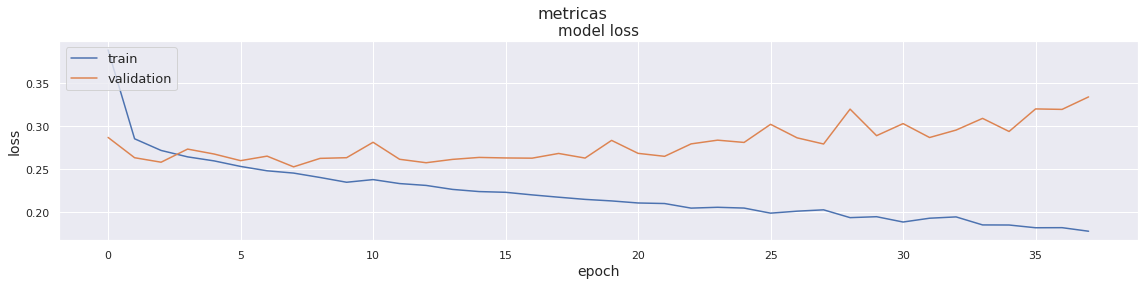

In [7]:
#normal weighted
data_normal = dataset_df[dataset_df.columns[1:]].to_numpy()
X_normal = data_normal[:,:-1]
y_normal = list(data_normal[:,-1].astype(int))
X_scaled_normal = preprocessing.scale(X_normal)
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(X_scaled_normal, y_normal, 
                                                                                test_size=0.2, stratify=y_normal)
scores_normal, reg_normal = runMLP(X_train_normal, X_test_normal, y_train_normal, y_test_normal, verbose=True)
y_pred_normal = (reg_normal.predict(X_test_normal)[:,1] > 0.5).astype(int)
print(confusion_matrix(y_test_normal, y_pred_normal))
print(classification_report(y_test_normal, y_pred_normal))

In [8]:
reg_normal.save("class_binario")

saving model to disk ... done!


In [12]:
reg_normal2 = Regressor()
history = reg_normal2.load("class_binario")
y_pred_normal = (reg_normal.predict(X_test_normal)[:,1] > 0.5).astype(int)
print(confusion_matrix(y_test_normal, y_pred_normal))
print(classification_report(y_test_normal, y_pred_normal))

loading model from disk ... done!
[[9120 1093]
 [  67  512]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     10213
           1       0.32      0.88      0.47       579

    accuracy                           0.89     10792
   macro avg       0.66      0.89      0.70     10792
weighted avg       0.96      0.89      0.91     10792



In [ ]:
%debug

> /usr/lib/python3.7/json/encoder.py(179)default()
    177 
    178         """
--> 179         raise TypeError(f'Object of type {o.__class__.__name__} '
    180                         f'is not JSON serializable')
    181 

ipdb> up
> /usr/lib/python3.7/json/encoder.py(438)_iterencode()
    436                     raise ValueError("Circular reference detected")
    437                 markers[markerid] = o
--> 438             o = _default(o)
    439             yield from _iterencode(o, _current_indent_level)
    440             if markers is not None:

ipdb> up
> /usr/lib/python3.7/json/encoder.py(325)_iterencode_list()
    323                 else:
    324                     chunks = _iterencode(value, _current_indent_level)
--> 325                 yield from chunks
    326         if newline_indent is not None:
    327             _current_indent_level -= 1

ipdb> up
> /usr/lib/python3.7/json/encoder.py(405)_iterencode_dict()
    403                 else:
    404                  

"{'val_loss': [0.3882205247064323, 0.3892233701448486, 0.3722405355636427, 0.3696286196913322, 0.3676528559144783, 0.3797724336976043, 0.367679591559596, 0.3530010158785329, 0.36073246831263145, 0.3472274132258478, 0.3499486294417424, 0.3573768934362059, 0.3555914148676234, 0.3549100039601257, 0.3552067143507936, 0.3738572689054408, 0.35113774010967463, 0.36816789864540983, 0.38925294449483205, 0.3469164726370444, 0.35620040283492554, 0.38748202197703346, 0.35724752136140103, 0.3530323540371787, 0.3518940295265045, 0.37680052454358637, 0.35859644231066623, 0.3573877327096679, 0.3867573443423496, 0.3863104775014626, 0.4112630255333065, 0.4111714425581874, 0.4411727467638778, 0.405487466874079, 0.4258841229495894, 0.43010212796374847, 0.40919582846611274, 0.41041126407809764], 'val_accuracy': [0.8599559664726257, 0.874203622341156, 0.8465191721916199, 0.8594926595687866, 0.8708444237709045, 0.867716908454895, 0.8838179111480713, 0.874435305595398, 0.8868296146392822, 0.8761728405952454, 

ipdb> eval(repr(self.kwargs["history"]))
{'val_loss': [0.3882205247064323, 0.3892233701448486, 0.3722405355636427, 0.3696286196913322, 0.3676528559144783, 0.3797724336976043, 0.367679591559596, 0.3530010158785329, 0.36073246831263145, 0.3472274132258478, 0.3499486294417424, 0.3573768934362059, 0.3555914148676234, 0.3549100039601257, 0.3552067143507936, 0.3738572689054408, 0.35113774010967463, 0.36816789864540983, 0.38925294449483205, 0.3469164726370444, 0.35620040283492554, 0.38748202197703346, 0.35724752136140103, 0.3530323540371787, 0.3518940295265045, 0.37680052454358637, 0.35859644231066623, 0.3573877327096679, 0.3867573443423496, 0.3863104775014626, 0.4112630255333065, 0.4111714425581874, 0.4411727467638778, 0.405487466874079, 0.4258841229495894, 0.43010212796374847, 0.40919582846611274, 0.41041126407809764], 'val_accuracy': [0.8599559664726257, 0.874203622341156, 0.8465191721916199, 0.8594926595687866, 0.8708444237709045, 0.867716908454895, 0.8838179111480713, 0.874435305595398, 

In [65]:
# normal weighted cross validation
data_normal = dataset_df[dataset_df.columns[1:]].to_numpy()
X_normal = data_normal[:,:-1]
y_normal = data_normal[:,-1].astype(int)
X_scaled_normal = preprocessing.scale(X_normal)
outs_normal = cv_mlp(X_scaled_normal, y_normal, cv=10)
probs(outs_normal)

iteration!...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               1600      
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 22,002
Trainable params: 22,002
Non-trainable params: 0
_________________________________________________________________
{0: 0.5283544413979196, 1: 9.316960859554873}
Epoch 00040: early stopping
evaluando test
5397/5397 [==============================] - 0s 58us/step
    EVALUATION RESULTS :  
loss: 0.18
accuracy: 0.92
accuracy_1: 0.92
iteration!...
Mod

{0: 0.5283647046023283, 1: 9.313770617568085}
Epoch 00035: early stopping
evaluando test
5395/5395 [==============================] - 0s 68us/step
    EVALUATION RESULTS :  
loss: 0.21
accuracy: 0.91
accuracy_1: 0.91
iteration!...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1600      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 22,002
Trainable params: 22,002
Non-trainable params: 0
_________________________________________________________________
{0: 0.52836470460

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               1600      
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 22,002
Trainable params: 22,002
Non-trainable params: 0
_________________________________________________________________
{0: 0.9997842037116962, 1: 1.000215889464594}
Train on 3706 samples, validate on 927 samples
Epoch 1/500
3706/3706 [==============================] - 0s 62us/step - loss: 0.6414 - accuracy: 0.7005 - accuracy_1: 0.7005 - val_loss: 0.5617 - val_accur

3706/3706 [==============================] - 0s 36us/step - loss: 0.1820 - accuracy: 0.9226 - accuracy_1: 0.9226 - val_loss: 0.2765 - val_accuracy: 0.8921 - val_accuracy_1: 0.8921
Epoch 39/500
3706/3706 [==============================] - 0s 33us/step - loss: 0.1789 - accuracy: 0.9253 - accuracy_1: 0.9253 - val_loss: 0.2849 - val_accuracy: 0.8997 - val_accuracy_1: 0.8997
Epoch 40/500
3706/3706 [==============================] - 0s 34us/step - loss: 0.1815 - accuracy: 0.9255 - accuracy_1: 0.9255 - val_loss: 0.2726 - val_accuracy: 0.8932 - val_accuracy_1: 0.8932
Epoch 41/500
3706/3706 [==============================] - 0s 33us/step - loss: 0.1796 - accuracy: 0.9234 - accuracy_1: 0.9234 - val_loss: 0.2914 - val_accuracy: 0.8986 - val_accuracy_1: 0.8986
Epoch 42/500
3706/3706 [==============================] - 0s 35us/step - loss: 0.1836 - accuracy: 0.9231 - accuracy_1: 0.9231 - val_loss: 0.2674 - val_accuracy: 0.8932 - val_accuracy_1: 0.8932
Epoch 00042: early stopping
evaluando test
1159/

ValueError: Error when checking input: expected dense_5_input to have shape (16,) but got array with shape (15,)

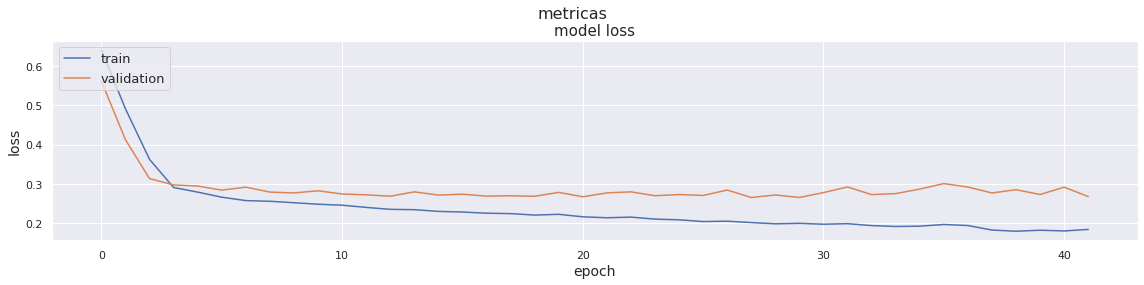

In [91]:
#downsampled

# Separate majority and minority classes
df_majority = dataset_df[dataset_df.Target==0]
df_minority = dataset_df[dataset_df.Target==1]

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2896,     # to match minority class
                                 random_state=123) # reproducible results

df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.Target.value_counts()


data_downsampled = df_downsampled[df_downsampled.columns[1:]].to_numpy()
X_downsampled = data_downsampled[:,:-1]
y_downsampled = list(data_downsampled[:,-1].astype(int))
X_scaled_downsampled = preprocessing.scale(X_downsampled)
X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(
    X_scaled_downsampled, y_downsampled, test_size=0.2, stratify=y_downsampled)
scores_downsampled, reg_downsampled = runMLP(X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled, verbose=True, weight=True)
y_pred_downsampled = (reg_downsampled.predict(X_test_downsampled)[:,1] > 0.5).astype(int)
print(confusion_matrix(y_test_downsampled, y_pred_downsampled))
print(classification_report(y_test_downsampled, y_pred_downsampled))

(43165, 17) (43165, 16) (53957, 17) (53957, 17)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 100)               1700      
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 202       
Total params: 22,102
Trainable params: 22,102
Non-trainable params: 0
_________________________________________________________________
{0: 1.0, 1: 1.0}
Train on 65356 samples, validate on 16340 samples
Epoch 1/500
65356/65356 [==============================] - 2s 27us/step - loss: 0.3151 - accuracy: 0.8723 - accuracy_1: 0.8723 - val_

Epoch 38/500
65356/65356 [==============================] - 2s 31us/step - loss: 0.0921 - accuracy: 0.9770 - accuracy_1: 0.9770 - val_loss: 0.1175 - val_accuracy: 0.9705 - val_accuracy_1: 0.9705
Epoch 39/500
65356/65356 [==============================] - 2s 30us/step - loss: 0.0900 - accuracy: 0.9771 - accuracy_1: 0.9771 - val_loss: 0.1116 - val_accuracy: 0.9722 - val_accuracy_1: 0.9722
Epoch 40/500
65356/65356 [==============================] - 2s 30us/step - loss: 0.0905 - accuracy: 0.9775 - accuracy_1: 0.9775 - val_loss: 0.1154 - val_accuracy: 0.9706 - val_accuracy_1: 0.9706
Epoch 41/500
65356/65356 [==============================] - 2s 31us/step - loss: 0.0861 - accuracy: 0.9788 - accuracy_1: 0.9788 - val_loss: 0.1098 - val_accuracy: 0.9726 - val_accuracy_1: 0.9726
Epoch 42/500
65356/65356 [==============================] - 2s 31us/step - loss: 0.0831 - accuracy: 0.9804 - accuracy_1: 0.9804 - val_loss: 0.1102 - val_accuracy: 0.9742 - val_accuracy_1: 0.9742
Epoch 43/500
65356/65356 

65356/65356 [==============================] - 2s 30us/step - loss: 0.0529 - accuracy: 0.9891 - accuracy_1: 0.9891 - val_loss: 0.1079 - val_accuracy: 0.9767 - val_accuracy_1: 0.9767
Epoch 81/500
65356/65356 [==============================] - 2s 31us/step - loss: 0.0509 - accuracy: 0.9901 - accuracy_1: 0.9901 - val_loss: 0.1031 - val_accuracy: 0.9769 - val_accuracy_1: 0.9769
Epoch 82/500
65356/65356 [==============================] - 2s 30us/step - loss: 0.0527 - accuracy: 0.9894 - accuracy_1: 0.9894 - val_loss: 0.1097 - val_accuracy: 0.9780 - val_accuracy_1: 0.9780
Epoch 83/500
65356/65356 [==============================] - 2s 31us/step - loss: 0.0551 - accuracy: 0.9883 - accuracy_1: 0.9883 - val_loss: 0.1286 - val_accuracy: 0.9741 - val_accuracy_1: 0.9741
Epoch 84/500
65356/65356 [==============================] - 2s 30us/step - loss: 0.0597 - accuracy: 0.9868 - accuracy_1: 0.9868 - val_loss: 0.1068 - val_accuracy: 0.9774 - val_accuracy_1: 0.9774
Epoch 85/500
65356/65356 [============

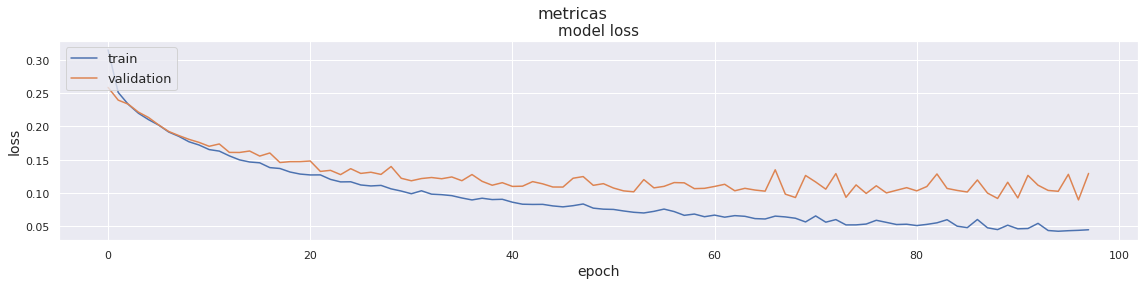

In [94]:
# upsampled

data0 = dataset_df.to_numpy()
X0 = data0[:,:-1]
y0 = list(data0[:,-1].astype(int))
X_scaled0 = preprocessing.scale(X0)
X_train0, X_test0, y_train0, y_test0 = train_test_split(X_scaled0, y0, test_size=0.2, stratify=y0)
data_train0 = pd.DataFrame(X_train0)
data_train0["Target"] = y_train0
print(data_train0.shape, X_train0.shape, data0.shape, dataset_df.shape)


# Separate majority and minority classes
df_majority = data_train0[data_train0.Target==0]
df_minority = data_train0[data_train0.Target==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample without replacement
                                 n_samples=40848,     # to match minority class
                                 random_state=1234) # reproducible results

df_upsampled = pd.concat([df_minority_upsampled, df_majority])
df_upsampled.Target.value_counts()
# pd.DataFrame(df_minority_upsampled)


data_upsampled = df_upsampled.to_numpy()
# X = data[:,:-1]
# y = list(data[:,-1].astype(int))
# X_scaled = preprocessing.scale(X)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)
X_train_upsampled = data_upsampled[:,:-1]
y_train_upsampled = data_upsampled[:,-1]
X_test_upsampled = X_test0
y_test_upsampled = y_test0
scores_upsampled, reg_upsampled = runMLP(X_train_upsampled, X_test_upsampled, y_train_upsampled, 
                                         y_test_upsampled, verbose=True)
y_pred_upsampled = (reg_upsampled.predict(X_test_upsampled)[:,1] > 0.5).astype(int)
print(confusion_matrix(y_test_upsampled, y_pred_upsampled))
print(classification_report(y_test_upsampled, y_pred_upsampled))

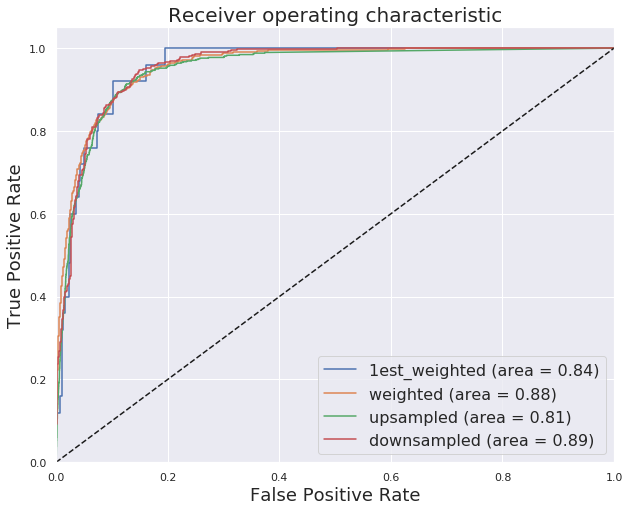

In [136]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.figure(figsize=(10,8))
for classifier, label, y_tst, X_tst in zip([reg_single, reg_normal, reg_upsampled, reg_downsampled],
                                    ["1est_weighted", "weighted", "upsampled", "downsampled"],
                                    [y_test_single, y_test_normal, y_test_upsampled, y_test_downsampled], 
                                    [X_test_single, X_test_normal, X_test_upsampled, X_test_downsampled]):
    proba = classifier.predict(X_tst)
    class_pred = (proba[:,1] > 0.5).astype(int)
    cl_roc_auc = roc_auc_score(y_tst, class_pred)
    fpr, tpr, thresholds = roc_curve(y_tst, proba[:,1])
    plt.plot(fpr, tpr, label='%s (area = %0.2f)' % (label,cl_roc_auc))

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.savefig('Log_ROC')
plt.show()
    

In [123]:
xx = X_test_normal[np.where(np.array(y_test_normal, dtype=int) == 1)[0]]
proba = reg_normal.predict(xx)
proba[:,1][proba[:,1] > 0.5]

array([0.9532539 , 0.98037016, 0.91668785, 0.8872894 , 0.92768806,
       0.9808318 , 0.64415395, 0.96995217, 0.99779236, 0.99962187,
       0.908775  , 0.89110005, 0.95456755, 0.93426245, 0.9436499 ,
       0.86940986, 0.9292686 , 0.9680719 , 0.9120591 , 0.95972514,
       0.9725159 , 0.93420285, 0.94863814, 0.9161621 , 0.97433203,
       0.90846276, 0.8563565 , 0.9405611 , 0.99641633, 0.8257392 ,
       0.9341557 , 0.7744528 , 0.93379176, 0.99846965, 0.98606306,
       0.98052293, 0.9628502 , 0.9315433 , 0.9096925 , 0.9818372 ,
       0.991206  , 0.96830094, 0.99561214, 0.9889234 , 0.998086  ,
       0.92112124, 0.968648  , 0.9871946 , 0.8547459 , 0.97361803,
       0.9081149 , 0.9431147 , 0.86391777, 0.98592967, 0.9746643 ,
       0.6355484 , 0.9850595 , 0.954571  , 0.9824024 , 0.98605114,
       0.959577  , 0.99468035, 0.9958637 , 0.98243034, 0.9624035 ,
       0.9723148 , 0.73873687, 0.91380525, 0.78896606, 0.8532912 ,
       0.99205095, 0.96384066, 0.992246  , 0.9495028 , 0.93645

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
No handles with labels found to put in legend.


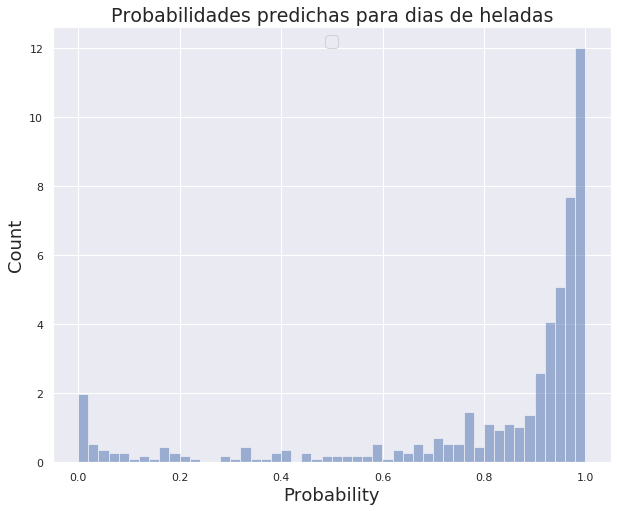

In [134]:
plt.figure(figsize=(10, 8))
# sns.distplot(svc.predict_proba(X_test)[:,0], hist=False, kde=True, bins=100, label="No-Helada")
proba = reg_normal.predict(xx)
plt.hist(proba[:,1], bins=50, normed=True, alpha=0.5, label="")
# sns.distplot(svc.predict_proba(X_test)[:,1], hist=False, kde=True, bins=100,label="Helada")
# plt.hist(proba[:,0], bins=50, normed=True, alpha=0.5, label="Pred. No-Helada (FP)")

plt.xlabel("Probability", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("Probabilidades predichas para dias de heladas", fontsize=19)
plt.legend(fontsize=16, loc="upper center")